In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=0
#%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import compare_psnr
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
[name[17:-4] for name in os.listdir(os.path.expanduser("~/Work/Projects/lca_subspace_vh/logfiles"))]

['8_3.0_0.3',
 '4_3.0_0.5',
 '8_4.0_0.3',
 '4_3.0_0.3',
 '4_3.0_0.4',
 '4_3.0_0.2',
 '8_3.0_0.4',
 '4_5.0_0.3',
 '8_5.0_0.3',
 '8_4.0_0.5',
 '8_5.0_0.2',
 '4_5.0_0.2',
 '10x_4_3.0_0.3',
 '8_4.0_0.2',
 '8_3.0_0.5',
 '8_3.0_0.2',
 '8_4.0_0.4',
 '4_3.0_0.3_5x',
 '4_4.0_0.4',
 '16_5.0_0.4',
 '8_5.0_0.4',
 '4_4.0_0.3',
 '4_4.0_0.2']

## Prelimiaries

In [141]:
class params:
    def __init__(self):
        self.model_type = "lca_subspace"
        self.model_name = "lca_subspace_vh"
#         self.version = "4_3.0_0.3"
        self.version = "5x_4_2.0_0.2"
        self.save_info = "analysis_train"
        self.overwrite_analysis_log = False
        
analysis_params = params()
analysis_params.project_dir = (os.path.expanduser("~")+"/Work/Projects/")
analysis_params.model_dir = (analysis_params.project_dir+analysis_params.model_name)

In [123]:
filtered_log_names

NameError: name 'filtered_log_names' is not defined

In [142]:
analyzer = ap.get_analyzer(analysis_params.model_type)
analyzer.setup(analysis_params)
analyzer.setup_model(analyzer.model_params)
analyzer.load_analysis(save_info=analysis_params.save_info)
analyzer.model_name = analysis_params.model_name

dataset = ds.get_data(analyzer.model_params)
dataset = analyzer.model.preprocess_dataset(dataset, analyzer.model_params)
dataset = analyzer.model.reshape_dataset(dataset, analyzer.model_params)
target_image = dataset["train"].images[0,...]

analyzer.model.num_groups = 4

INFO:preprocessing:FT Whitened train data
INFO:preprocessing:Extracted patches from train data


In [143]:
num_imgs = 100#data["train"].images.shape[0]
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config, graph=analyzer.model.graph) as sess:
  feed_dict = analyzer.model.get_feed_dict(dataset["train"].images[0:num_imgs,...])
  sess.run(analyzer.model.init_op, feed_dict)
  analyzer.model.load_full_model(sess, analyzer.analysis_params.cp_loc)
  run_list = [analyzer.model.module.w, analyzer.model.a, analyzer.model.module.group_activity, analyzer.model.module.group_angles]
  weights, neuron_activations, group_activations, group_angles = sess.run(run_list, feed_dict)
  weights_reshaped = weights.T.reshape(analyzer.model_params.num_neurons, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size)

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v5x_4_2.0_0.2-100000


In [144]:
analyzer.full_image

AttributeError: 'LcaSubspaceAnalyzer' object has no attribute 'full_image'

## Plot Weights (Phis)

In [8]:
def plot_group_weights(W, group_size, figsize=(10, 10)):
    num_groups = W.shape[0] // group_size
    assert isinstance(num_groups, int), "number of groups should have type int"
    fig, ax = plt.subplots(ncols=group_size, nrows=num_groups ,figsize=figsize)
    w_i = 0
    for r in range(group_size):
        for c in range(group_size):
            ax[r, c].imshow(W[w_i])
            break
            w_i += 1
        break
    plt.show()

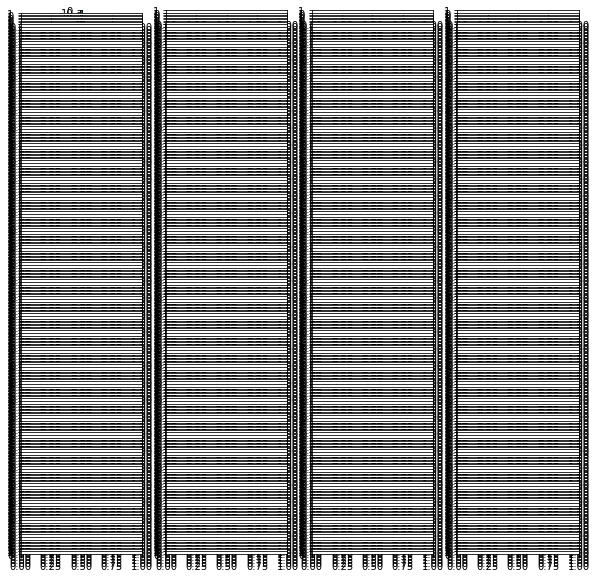

In [18]:
group_size = analyzer.model_params.num_neurons // analyzer.model_params.num_groups
plot_group_weights(weights_reshaped, group_size)

## Reconstruction of Full Image

['4_3.0_0.2', '4_3.0_0.3', '4_3.0_0.4', '4_3.0_0.5', '4_4.0_0.2', '4_4.0_0.3', '4_4.0_0.4', '4_5.0_0.2', '4_5.0_0.3', '8_3.0_0.2', '8_3.0_0.3', '8_3.0_0.4', '8_3.0_0.5', '8_4.0_0.2', '8_4.0_0.3', '8_4.0_0.4', '8_4.0_0.5', '8_5.0_0.2', '8_5.0_0.3', '8_5.0_0.4']
8_4.0_0.2


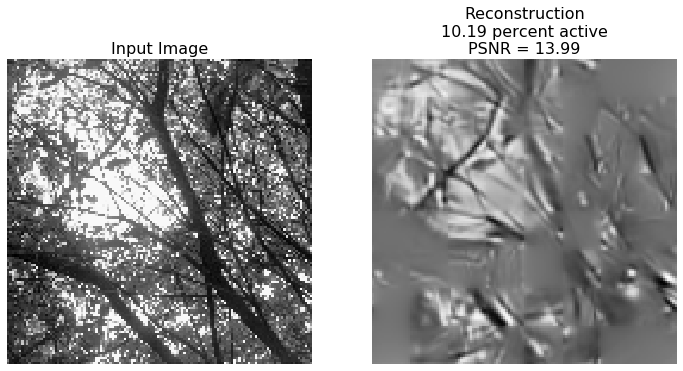

8_4.0_0.3


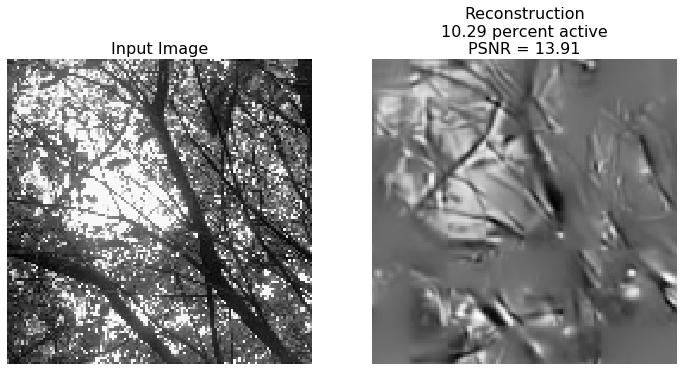

8_4.0_0.4


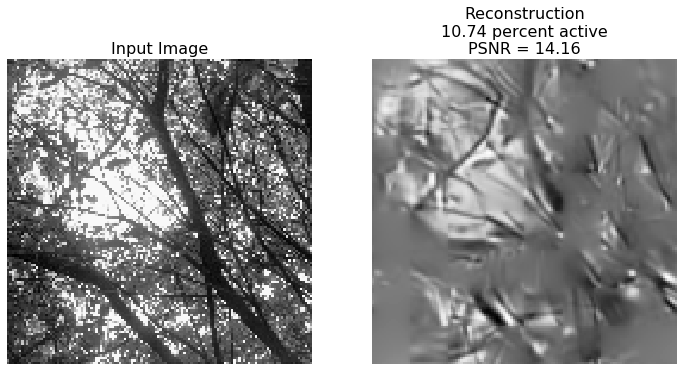

8_4.0_0.5


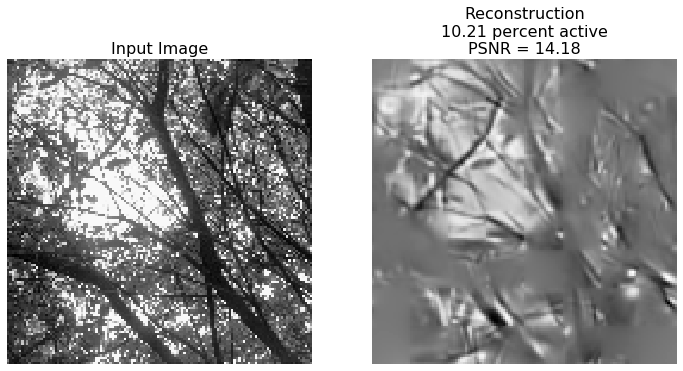

8_5.0_0.2


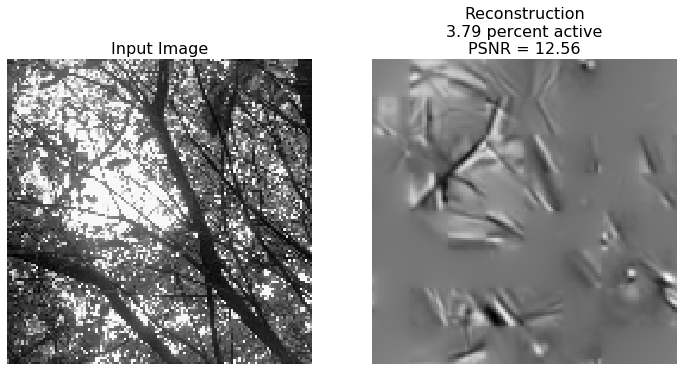

8_5.0_0.3


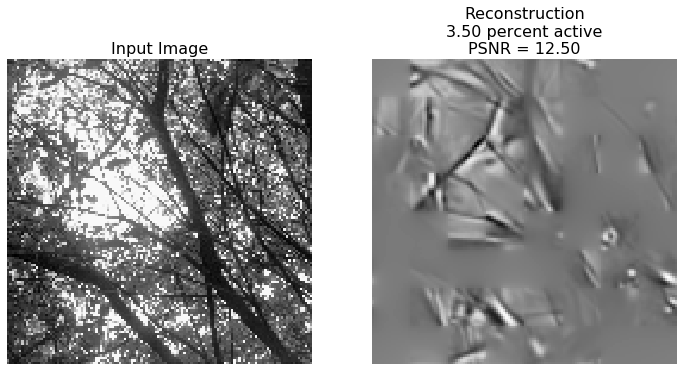

8_5.0_0.4


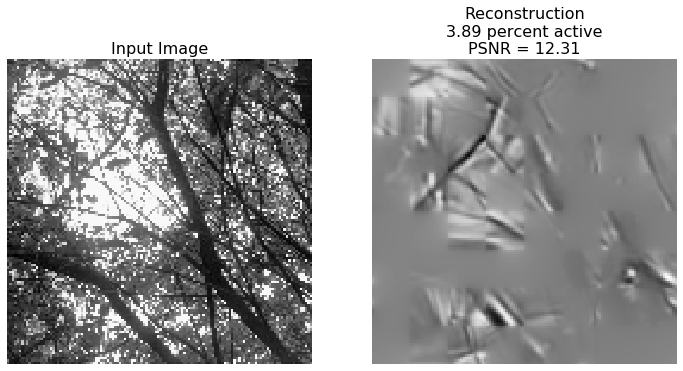

In [20]:
log_names = [name[17:-4] for name in os.listdir(os.path.expanduser("~/Work/Projects/lca_subspace_vh/logfiles"))]
log_names.sort()
log_names = log_names[1:]
log_names.pop(2)
filtered_log_names = log_names
print(filtered_log_names)

class params:
    def __init__(self, version):
        self.model_type = "lca_subspace"
        self.model_name = "lca_subspace_vh"
#         self.version = "4_3.0_0.3"
        self.version = version
        self.save_info = "analysis_train"
        self.overwrite_analysis_log = False
        
for v in filtered_log_names[13:]:
    print(v)
    analysis_params = params(v)
    analysis_params.project_dir = (os.path.expanduser("~")+"/Work/Projects/")
    analysis_params.model_dir = (analysis_params.project_dir+analysis_params.model_name)
    
    analyzer = ap.get_analyzer(analysis_params.model_type)
    analyzer.setup(analysis_params)
    analyzer.setup_model(analyzer.model_params)
    analyzer.load_analysis(save_info=analysis_params.save_info)
    analyzer.model_name = analysis_params.model_name

#     dataset = ds.get_data(analyzer.model_params)
#     dataset = analyzer.model.preprocess_dataset(dataset, analyzer.model_params)
#     dataset = analyzer.model.reshape_dataset(dataset, analyzer.model_params)

#     analyzer.model.num_groups = int(v[0])
    
#     keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
#     labels=["activity", "recon loss", "sparse loss", "total loss"]
#     stats_fig = pf.plot_stats(analyzer.run_stats, keys=keys, labels=labels, start_index=100, figsize=(10,10))
#     stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_train_stats.png")

    try:
        normed_image = (
          (analyzer.full_image - np.min(analyzer.full_image))
          / (np.max(analyzer.full_image) - np.min(analyzer.full_image))).astype(np.float32)

        normed_recon = (
          (analyzer.full_recon - np.min(analyzer.full_recon))
          / (np.max(analyzer.full_recon) - np.min(analyzer.full_recon))).astype(np.float32)

        fig, ax = plt.subplots(1, 2, figsize=(12,12))
        ax[0] = pf.clear_axis(ax[0])
        ax[0].imshow(np.squeeze(normed_image), cmap="Greys_r")
        ax[0].set_title("Input Image", fontsize=16)
        ax[1] = pf.clear_axis(ax[1])
        ax[1].imshow(np.squeeze(normed_recon), cmap="Greys_r")
        percent_active = "{:.2f}".format(analyzer.recon_frac_act*100)
        psnr = "{:.2f}".format(compare_psnr(normed_image, normed_recon, data_range=1))
        ax[1].set_title("Reconstruction\n"+percent_active+" percent active"+"\n"+"PSNR = "+psnr, fontsize=16)
        plt.show()
        fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_image_recon.png", transparent=True,
          bbox_inches="tight")
    except:
        print(v, "error")
        continue
    

In [154]:
if analyzer.model_params.whiten_data:
  # FT method is the only one that works on full images
  wht_img, img_mean, ft_filter = dp.whiten_data(full_image,
    method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
else:
  wht_img = full_image
img_patches = dp.extract_patches(wht_img,
  out_shape=(1, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size, 1),
  overlapping=False, randomize=False, var_thresh=0.0)
img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
model_eval = analyzer.evaluate_model(img_patches,
  ["inference/activity:0", "output/reconstruction:0"])
recon_patches = model_eval["output/reconstruction:0"]
a_vals = model_eval["inference/activity:0"]
recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
if analyzer.model_params.whiten_data:
    full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")

ValueError: not enough values to unpack (expected 4, got 1)

In [145]:
normed_image = (
  (analyzer.full_image - np.min(analyzer.full_image))
  / (np.max(analyzer.full_image) - np.min(analyzer.full_image))).astype(np.float32)

normed_recon = (
  (analyzer.full_recon - np.min(analyzer.full_recon))
  / (np.max(analyzer.full_recon) - np.min(analyzer.full_recon))).astype(np.float32)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(np.squeeze(normed_image), cmap="Greys_r")
ax[0].set_title("Input Image", fontsize=16)
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(np.squeeze(normed_recon), cmap="Greys_r")
percent_active = "{:.2f}".format(analyzer.recon_frac_act*100)
psnr = "{:.2f}".format(compare_psnr(normed_image, normed_recon, data_range=1))
ax[1].set_title("Reconstruction\n"+percent_active+" percent active"+"\n"+"PSNR = "+psnr, fontsize=16)
plt.show()
fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_image_recon.png", transparent=True,
  bbox_inches="tight")

AttributeError: 'LcaSubspaceAnalyzer' object has no attribute 'full_image'

## Location Frequency Terms

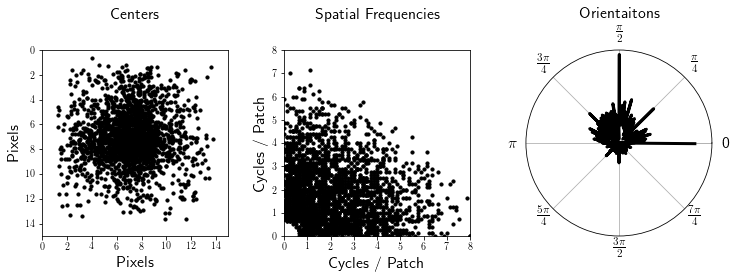

In [128]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats, figsize=(12, 4), fontsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/fig_location_frequency_centers.png")

'/home/ryanchan/Work/Projects/lca_subspace_vh/analysis/4_3.0_0.3/'

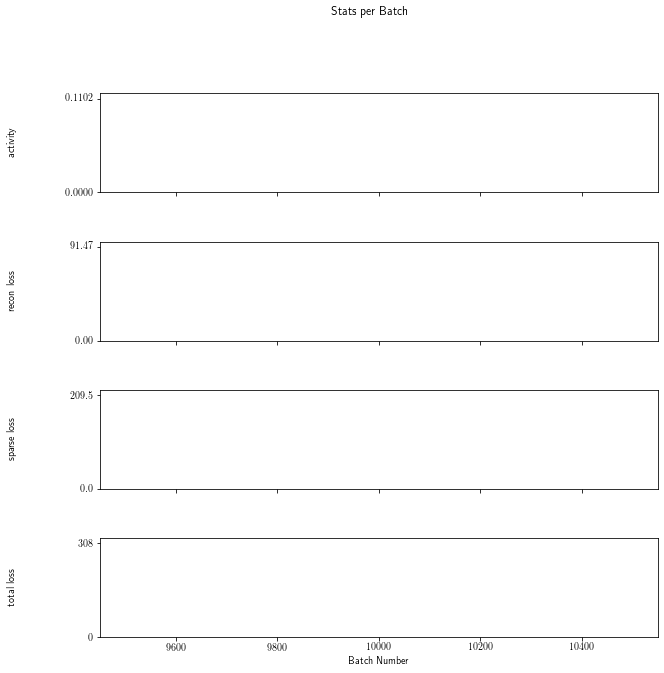

In [130]:
keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
labels=["activity", "recon loss", "sparse loss", "total loss"]
stats_fig = pf.plot_stats(analyzer.run_stats, keys=keys, labels=labels, start_index=100, figsize=(10,10))
stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_train_stats.png")

In [131]:
ot_fig = pf.plot_contrast_orientation_tuning(analyzer.ot_grating_responses["neuron_indices"],
  analyzer.ot_grating_responses["contrasts"],
  analyzer.ot_grating_responses["orientations"],
  analyzer.ot_grating_responses["mean_responses"])
ot_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_orientation_tuning.pdf")

AttributeError: 'LcaSubspaceAnalyzer' object has no attribute 'ot_grating_responses'

# iso-response

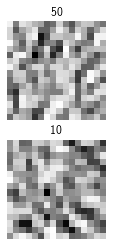

In [135]:
vector_id = 4
analyzer.bf_id0 = 50#vectors[vector_id, 0] # RICA 83, 85; vae 4, 72; lca 3, 588
analyzer.bf_id1 = 10#vectors[vector_id, 1]
fig, ax = plt.subplots(2)
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
ax[0].set_title(str(analyzer.bf_id0))
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
ax[1].set_title(str(analyzer.bf_id1))
plt.show()

In [133]:
analyzer.bf0 = analyzer.bf_stats["basis_functions"][analyzer.bf_id0].reshape(
(analyzer.model_params.num_pixels))
analyzer.bf1 = analyzer.bf_stats["basis_functions"][analyzer.bf_id1].reshape(
(analyzer.model_params.num_pixels))
analyzer.bf0_norm = np.linalg.norm(analyzer.bf0)
analyzer.bf1_norm = np.linalg.norm(analyzer.bf1)
analyzer.bf0 = analyzer.bf0 / analyzer.bf0_norm
analyzer.bf1 = analyzer.bf1 / analyzer.bf1_norm

print("BF indices = [",analyzer.bf_id0,", ",analyzer.bf_id1,"]")
print("bf0 norm = ", analyzer.bf0_norm)
print("bf1 norm = ", analyzer.bf1_norm)

BF indices = [ 50 ,  10 ]
bf0 norm =  1.0
bf1 norm =  1.0


In [134]:
num_imgs = int(228**2)
x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
proj_datapoints = np.stack([X_mesh.reshape(num_imgs), Y_mesh.reshape(num_imgs)], axis=1)

analyzer.proj_datapoints = proj_datapoints
analyzer.proj_matrix, v = analyzer.bf_projections(analyzer.bf0, analyzer.bf1)
analyzer.proj_neuron0 = np.dot(analyzer.proj_matrix, analyzer.bf0).T
analyzer.proj_neuron1 = np.dot(analyzer.proj_matrix, analyzer.bf1).T
analyzer.proj_v = np.dot(analyzer.proj_matrix, v).T

analyzer.datapoints = np.stack([np.dot(analyzer.proj_matrix.T, analyzer.proj_datapoints[data_id,:])
for data_id in range(num_imgs)]) #inject
analyzer.datapoints, orig_shape = dp.reshape_data(analyzer.datapoints, flatten=False)[:2]
analyzer.datapoints = {"test": Dataset(analyzer.datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
params={"whiten_data":analyzer.model_params.whiten_data}
if params["whiten_data"]:
    params["whiten_method"] = analyzer.model_params.whiten_method
analyzer.datapoints = analyzer.model.preprocess_dataset(analyzer.datapoints, params=params)
analyzer.datapoints = analyzer.model.reshape_dataset(analyzer.datapoints, analyzer.model_params)
analyzer.datapoints["test"].images /= np.max(np.abs(analyzer.datapoints["test"].images))
analyzer.datapoints["test"].images *= 3*analyzer.analysis_params.input_scale

In [56]:
activations = analyzer.compute_activations(analyzer.datapoints["test"].images)
#activations = analyzer.evaluate_model(analyzer.datapoints["test"].images, [analyzer.model.module.u_list[1].name])[analyzer.model.module.u_list[1].name]
activity_max = np.amax(np.abs(activations)) # Rescale between -1 and 1
analyzer.norm_activity = activations / (activity_max + 0.00001)

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v8_5.0_0.4-1000000


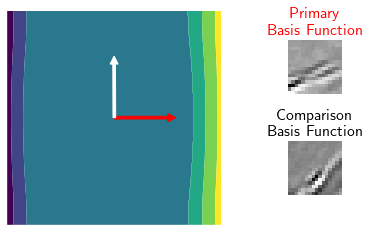

In [57]:
num_plots_y = 1
num_plots_x = 2
gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
fig = plt.figure(figsize=(6,6))
curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
#cmap = plt.get_cmap('tab20b')
cmap = plt.get_cmap('viridis')
vmin = np.floor(np.min(analyzer.norm_activity))#0.0
vmax = np.ceil(np.max(analyzer.norm_activity))#1.0

#name_suffix = "continuous"
#pts = curve_ax.scatter(analyzer.proj_datapoints[:,0], analyzer.proj_datapoints[:,1],
#  vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.5, c=analyzer.norm_activity[:, analyzer.bf_id0], s=5.0)

levels = 5
name_suffix = ""
contsf = curve_ax.contourf(X_mesh, Y_mesh,
analyzer.norm_activity[:,analyzer.bf_id0].reshape(int(np.sqrt(num_imgs)),
int(np.sqrt(num_imgs))), levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

curve_ax.arrow(0, 0, analyzer.proj_neuron0[0].item(),
analyzer.proj_neuron0[1].item(), width=0.05, head_width=0.15,
head_length=0.15, fc='r', ec='r')
curve_ax.arrow(0, 0, analyzer.proj_neuron1[0].item(),
analyzer.proj_neuron1[1].item(), width=0.05, head_width=0.15,
head_length=0.15, fc='w', ec='w')
#curve_ax.arrow(0, 0, analyzer.proj_v[0].item(), analyzer.proj_v[1].item(), width=0.05, head_width=0.15,
# head_length=0.15, linestyle="-.", fc='k', ec='k')

#curve_ax.set_title("Angle = "+"{:.2f}".format(analyzer.neuron_angles[bf_id0, bf_id1])+" deg", fontsize=16)
curve_ax.set_ylim([-2, 2.0])
curve_ax.set_xlim([-2, 2.0])
curve_ax.set_aspect("equal")
#cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
#cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.55)
bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
bf1_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
bf1_ax.set_title("Primary\nBasis Function", color='r', fontsize=16)
bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
bf2_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
bf2_ax.set_title("Comparison\nBasis Function", color='k', fontsize=16)
fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_response_contours_bf0id"+str(analyzer.bf_id0)+"_bf1id"+str(analyzer.bf_id1)+name_suffix+".png",
transparent=True, bbox_inches="tight", pad_inches=0.01)
plt.show()

working on  0 1
BF indices = [ 0 ,  1 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


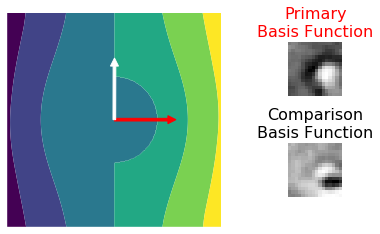

working on  0 2
BF indices = [ 0 ,  2 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


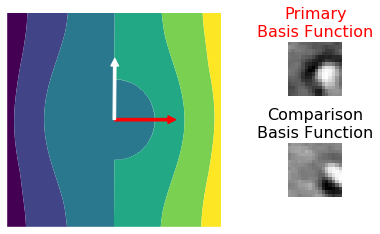

working on  0 3
BF indices = [ 0 ,  3 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


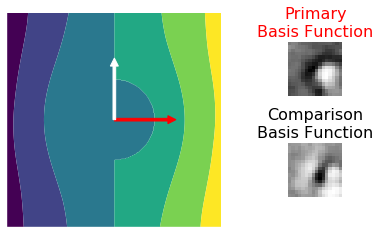

working on  4 4
BF indices = [ 4 ,  4 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


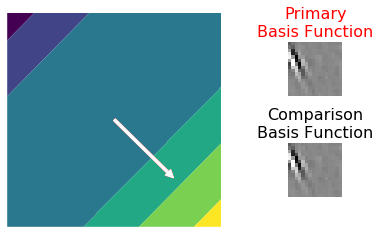

working on  4 5
BF indices = [ 4 ,  5 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


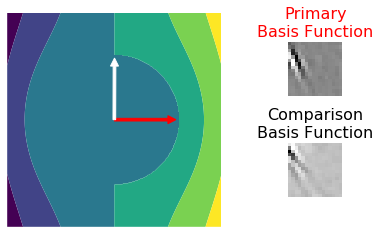

working on  4 6
BF indices = [ 4 ,  6 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


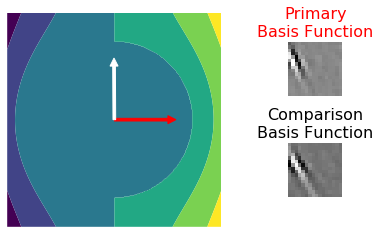

working on  4 7
BF indices = [ 4 ,  7 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


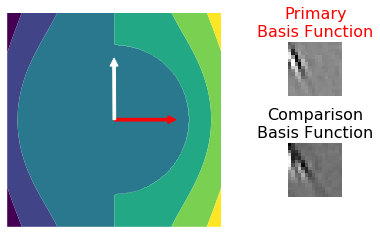

working on  8 8
BF indices = [ 8 ,  8 ]
bf0 norm =  1.0
bf1 norm =  1.0


/home/ryanchan/DeepSparseCoding/utils/data_processing.py:1100: RuntimeWarning: invalid value encountered in true_divide
  v = np.squeeze((v / np.linalg.norm(v)).T)


INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


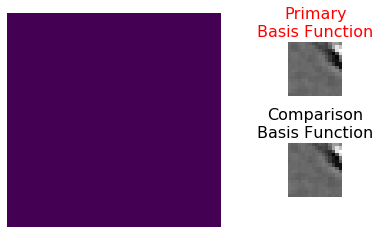

working on  8 9
BF indices = [ 8 ,  9 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


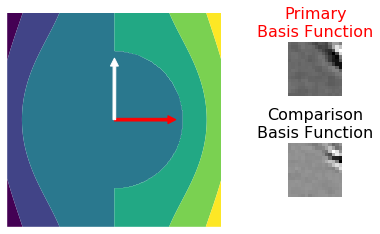

working on  8 10
BF indices = [ 8 ,  10 ]
bf0 norm =  1.0
bf1 norm =  0.9999999
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


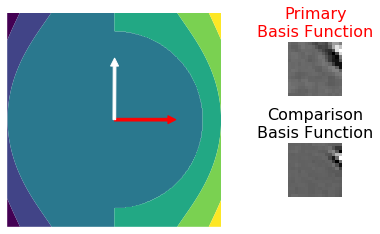

working on  8 11
BF indices = [ 8 ,  11 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


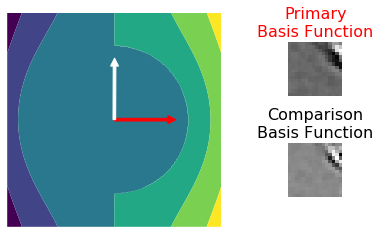

working on  12 12
BF indices = [ 12 ,  12 ]
bf0 norm =  0.9999998
bf1 norm =  0.9999998
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


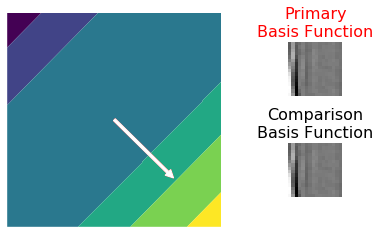

working on  12 13
BF indices = [ 12 ,  13 ]
bf0 norm =  0.9999998
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


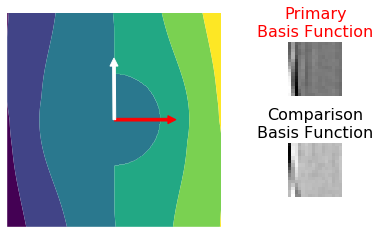

working on  12 14
BF indices = [ 12 ,  14 ]
bf0 norm =  0.9999998
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


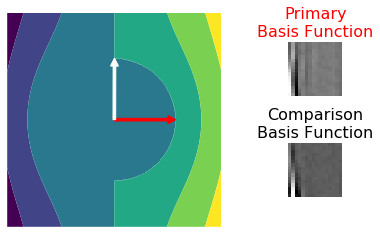

working on  12 15
BF indices = [ 12 ,  15 ]
bf0 norm =  0.9999998
bf1 norm =  0.9999998
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


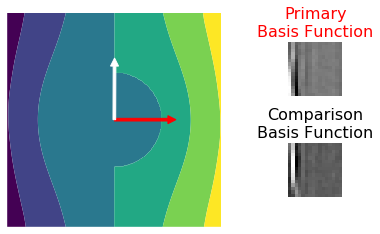

working on  16 16
BF indices = [ 16 ,  16 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


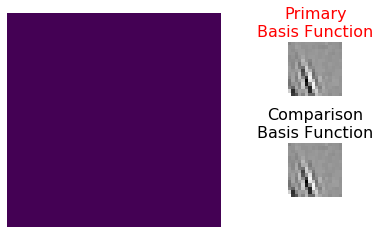

working on  16 17
BF indices = [ 16 ,  17 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


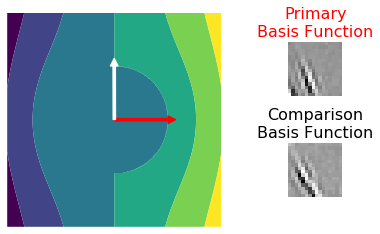

working on  16 18
BF indices = [ 16 ,  18 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


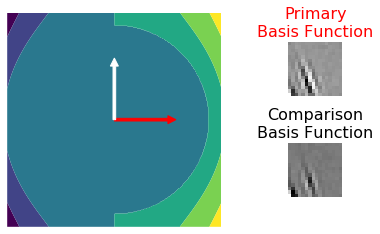

working on  16 19
BF indices = [ 16 ,  19 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


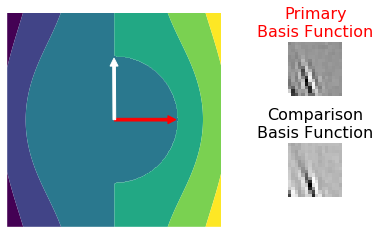

working on  20 20
BF indices = [ 20 ,  20 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


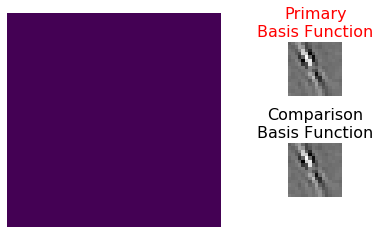

working on  20 21
BF indices = [ 20 ,  21 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


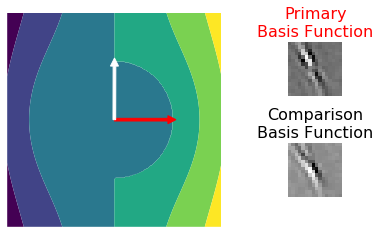

working on  20 22
BF indices = [ 20 ,  22 ]
bf0 norm =  1.0
bf1 norm =  0.9999999
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


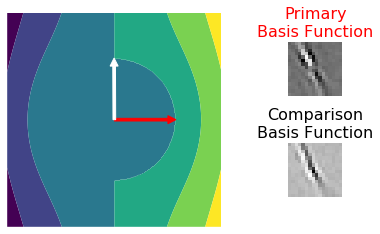

working on  20 23
BF indices = [ 20 ,  23 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


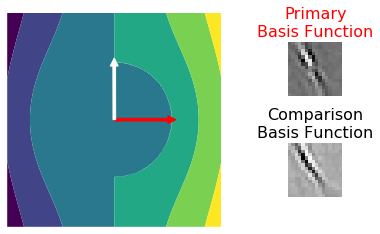

working on  24 24
BF indices = [ 24 ,  24 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


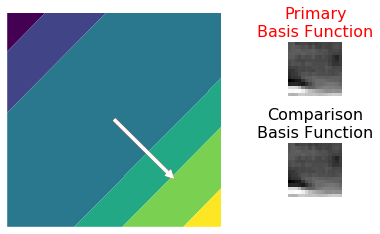

working on  24 25
BF indices = [ 24 ,  25 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


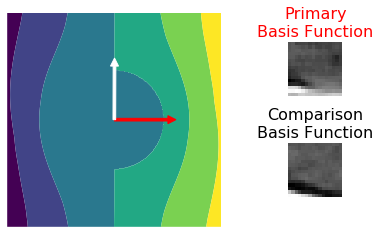

working on  24 26
BF indices = [ 24 ,  26 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


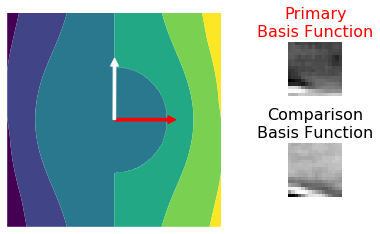

working on  24 27
BF indices = [ 24 ,  27 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


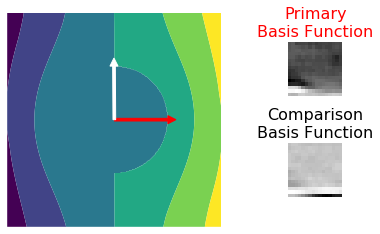

working on  28 28
BF indices = [ 28 ,  28 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


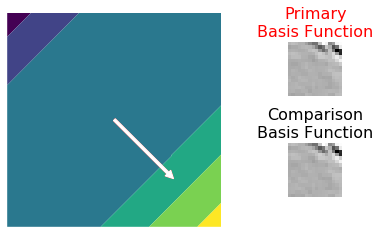

working on  28 29
BF indices = [ 28 ,  29 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


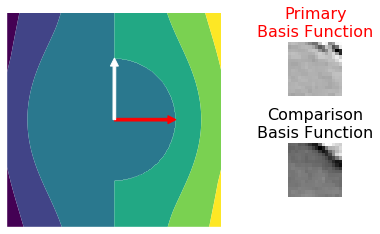

working on  28 30
BF indices = [ 28 ,  30 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


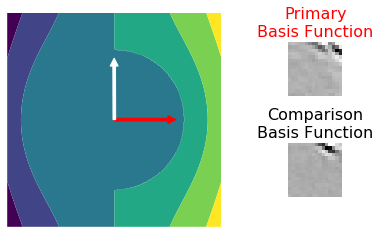

working on  28 31
BF indices = [ 28 ,  31 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


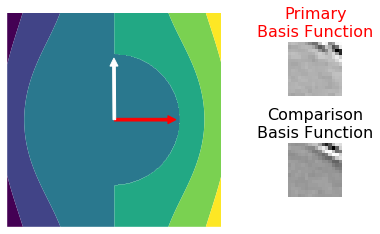

working on  32 32
BF indices = [ 32 ,  32 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


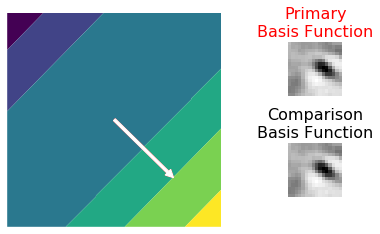

working on  32 33
BF indices = [ 32 ,  33 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


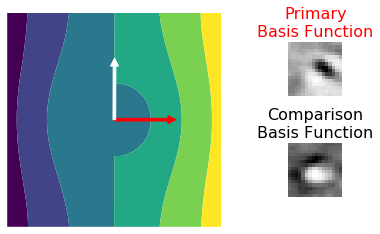

working on  32 34
BF indices = [ 32 ,  34 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


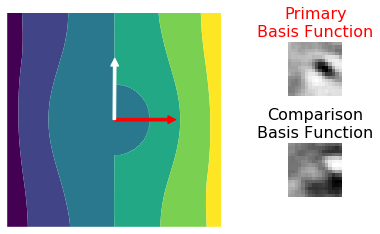

working on  32 35
BF indices = [ 32 ,  35 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


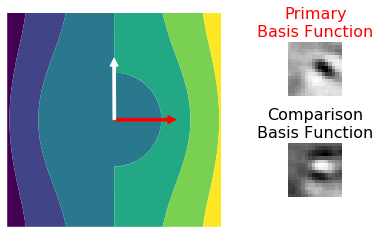

working on  36 36
BF indices = [ 36 ,  36 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


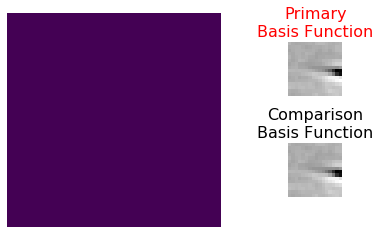

working on  36 37
BF indices = [ 36 ,  37 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


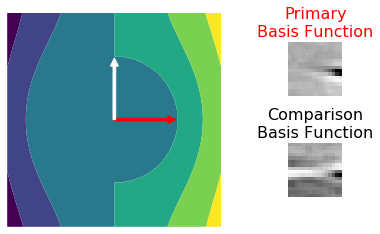

working on  36 38
BF indices = [ 36 ,  38 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


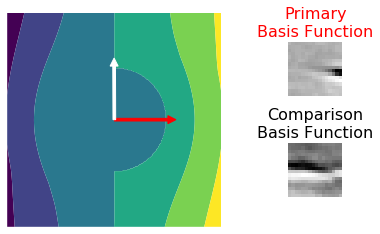

working on  36 39
BF indices = [ 36 ,  39 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


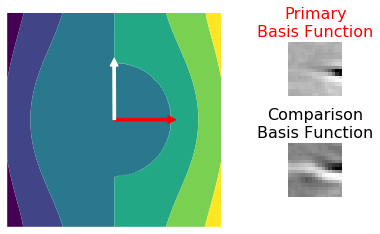

working on  40 40
BF indices = [ 40 ,  40 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


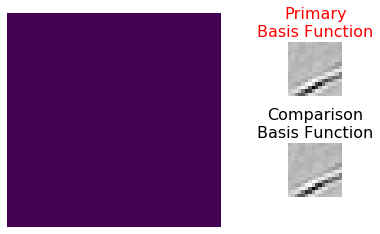

working on  40 41
BF indices = [ 40 ,  41 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


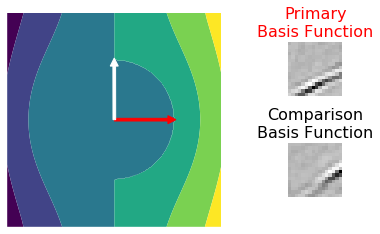

working on  40 42
BF indices = [ 40 ,  42 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


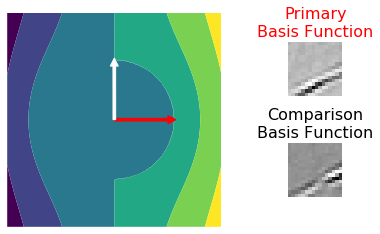

working on  40 43
BF indices = [ 40 ,  43 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


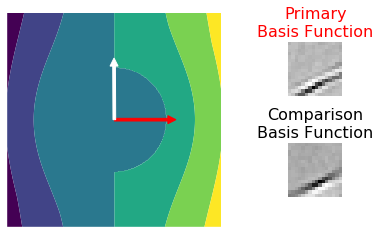

working on  44 44
BF indices = [ 44 ,  44 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


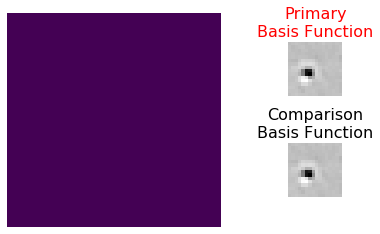

working on  44 45
BF indices = [ 44 ,  45 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


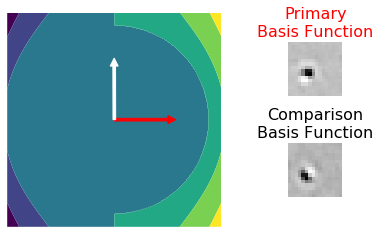

working on  44 46
BF indices = [ 44 ,  46 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


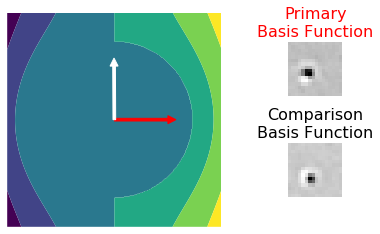

working on  44 47
BF indices = [ 44 ,  47 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


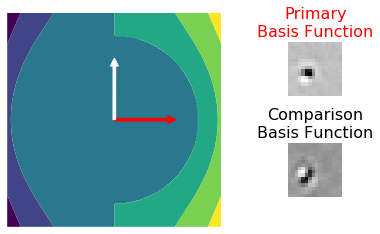

working on  48 48
BF indices = [ 48 ,  48 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


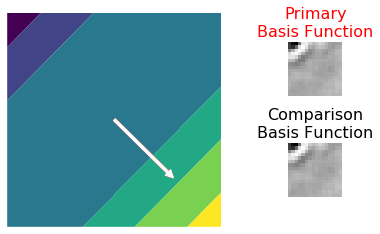

working on  48 49
BF indices = [ 48 ,  49 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


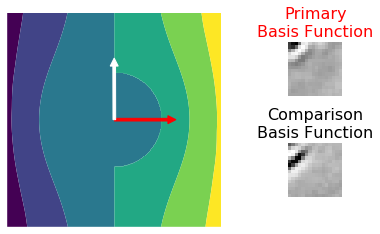

working on  48 50
BF indices = [ 48 ,  50 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


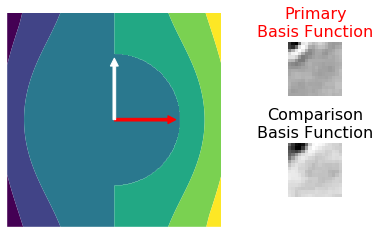

working on  48 51
BF indices = [ 48 ,  51 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


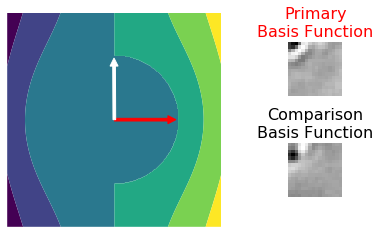

working on  52 52
BF indices = [ 52 ,  52 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


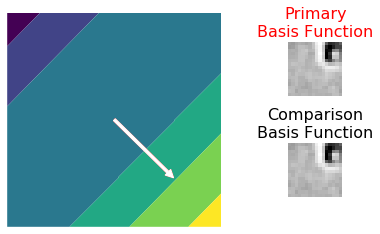

working on  52 53
BF indices = [ 52 ,  53 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


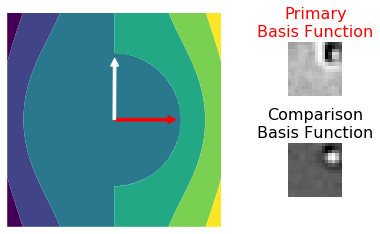

working on  52 54
BF indices = [ 52 ,  54 ]
bf0 norm =  1.0
bf1 norm =  0.9999999
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


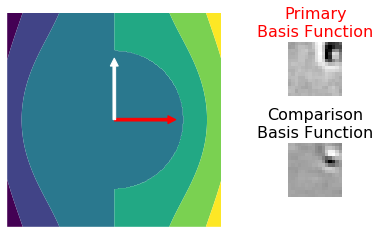

working on  52 55
BF indices = [ 52 ,  55 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


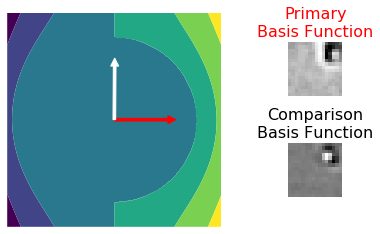

working on  56 56
BF indices = [ 56 ,  56 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


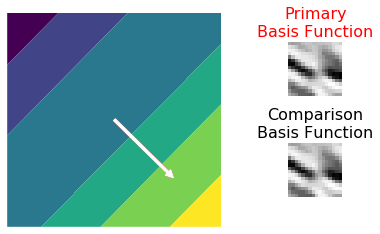

working on  56 57
BF indices = [ 56 ,  57 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


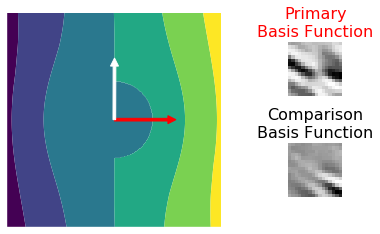

working on  56 58
BF indices = [ 56 ,  58 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


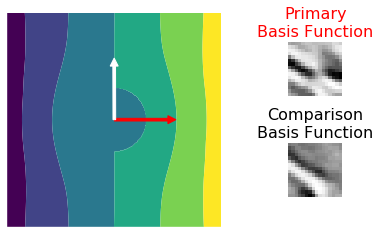

working on  56 59
BF indices = [ 56 ,  59 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


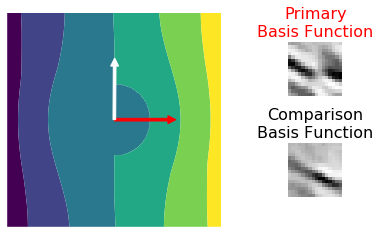

working on  60 60
BF indices = [ 60 ,  60 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


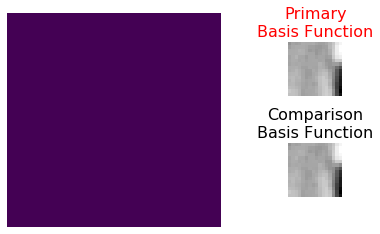

working on  60 61
BF indices = [ 60 ,  61 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


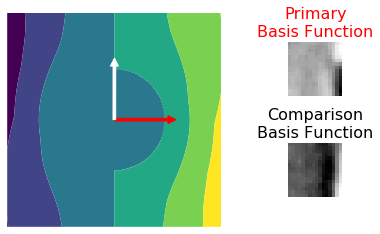

working on  60 62
BF indices = [ 60 ,  62 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


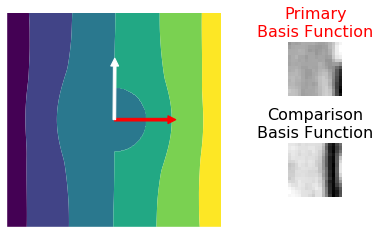

working on  60 63
BF indices = [ 60 ,  63 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


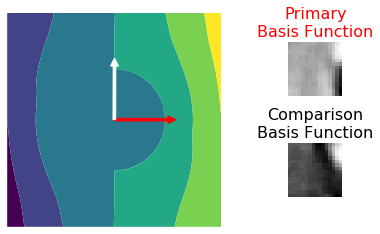

working on  64 64
BF indices = [ 64 ,  64 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


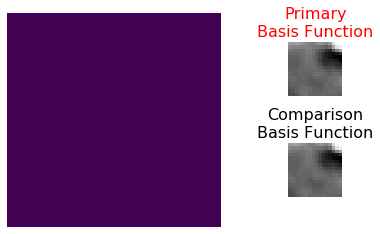

working on  64 65
BF indices = [ 64 ,  65 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


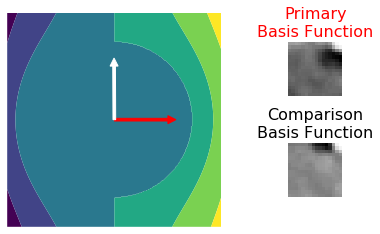

working on  64 66
BF indices = [ 64 ,  66 ]
bf0 norm =  1.0
bf1 norm =  0.9999999
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


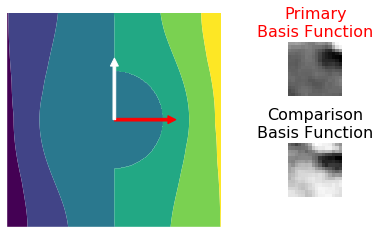

working on  64 67
BF indices = [ 64 ,  67 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


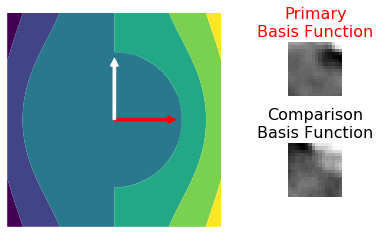

working on  68 68
BF indices = [ 68 ,  68 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


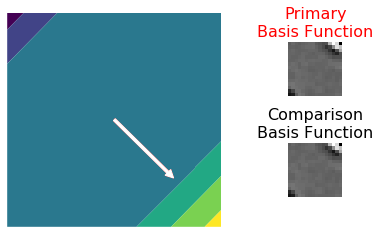

working on  68 69
BF indices = [ 68 ,  69 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


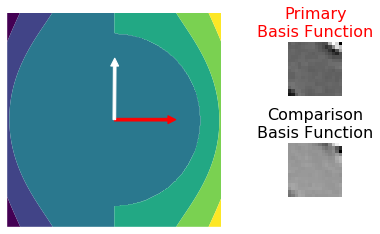

working on  68 70
BF indices = [ 68 ,  70 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


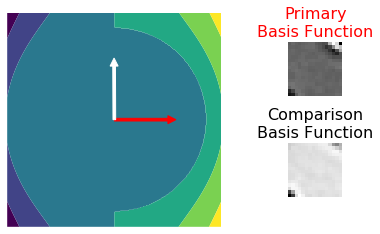

working on  68 71
BF indices = [ 68 ,  71 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


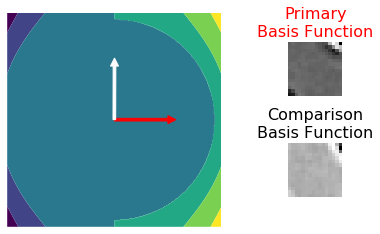

working on  72 72
BF indices = [ 72 ,  72 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


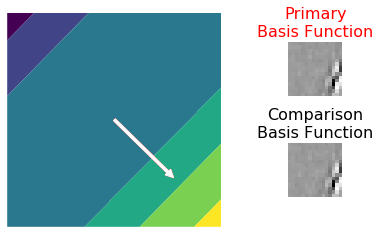

working on  72 73
BF indices = [ 72 ,  73 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


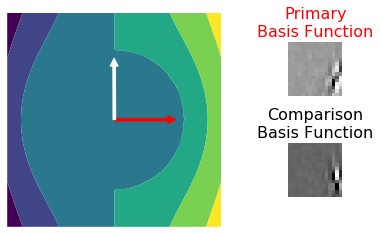

working on  72 74
BF indices = [ 72 ,  74 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


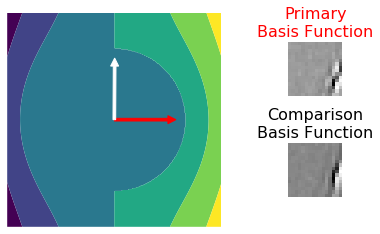

working on  72 75
BF indices = [ 72 ,  75 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


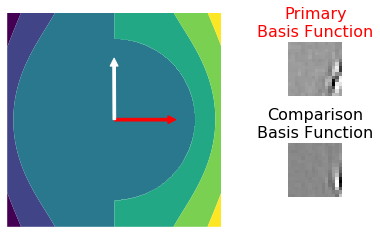

working on  76 76
BF indices = [ 76 ,  76 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


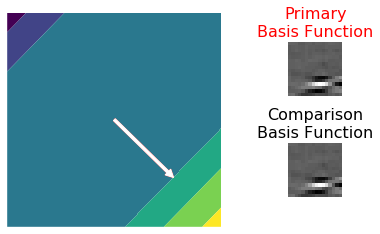

working on  76 77
BF indices = [ 76 ,  77 ]
bf0 norm =  0.99999994
bf1 norm =  0.9999999
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


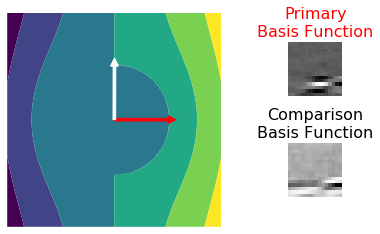

working on  76 78
BF indices = [ 76 ,  78 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


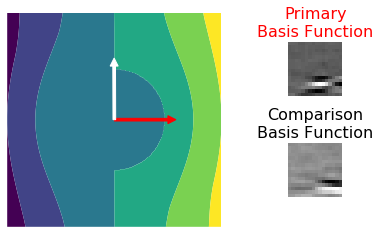

working on  76 79
BF indices = [ 76 ,  79 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


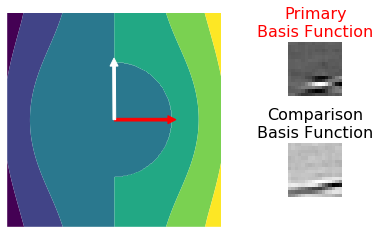

working on  80 80
BF indices = [ 80 ,  80 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


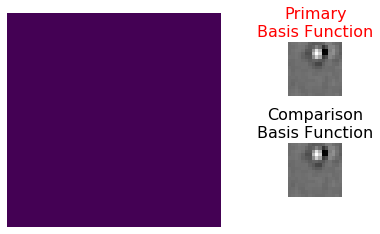

working on  80 81
BF indices = [ 80 ,  81 ]
bf0 norm =  1.0
bf1 norm =  0.9999999
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


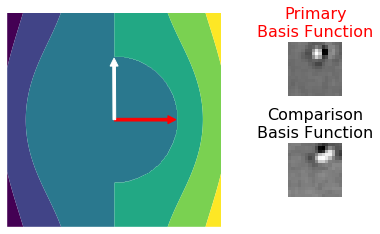

working on  80 82
BF indices = [ 80 ,  82 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


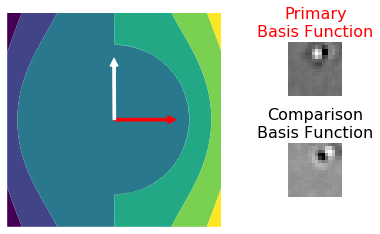

working on  80 83
BF indices = [ 80 ,  83 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


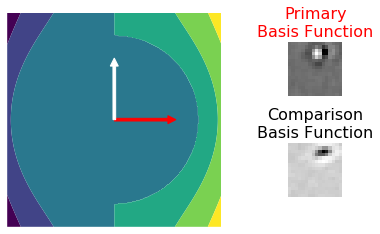

working on  84 84
BF indices = [ 84 ,  84 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


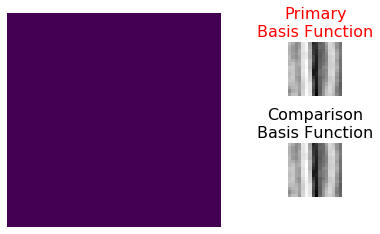

working on  84 85
BF indices = [ 84 ,  85 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


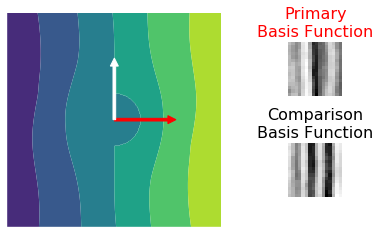

working on  84 86
BF indices = [ 84 ,  86 ]
bf0 norm =  1.0
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


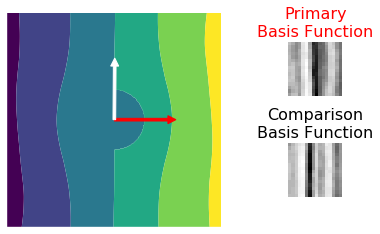

working on  84 87
BF indices = [ 84 ,  87 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


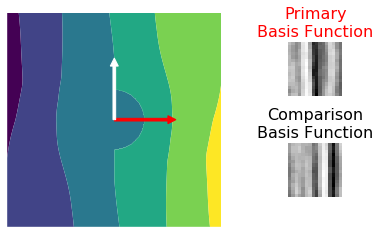

working on  88 88
BF indices = [ 88 ,  88 ]
bf0 norm =  0.99999994
bf1 norm =  0.99999994
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


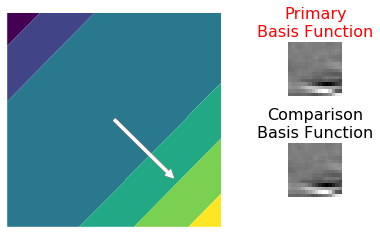

working on  88 89
BF indices = [ 88 ,  89 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


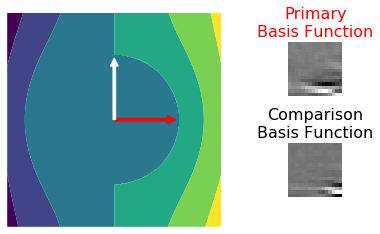

working on  88 90
BF indices = [ 88 ,  90 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


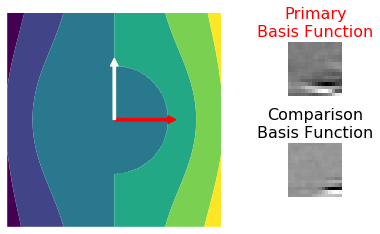

working on  88 91
BF indices = [ 88 ,  91 ]
bf0 norm =  0.99999994
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


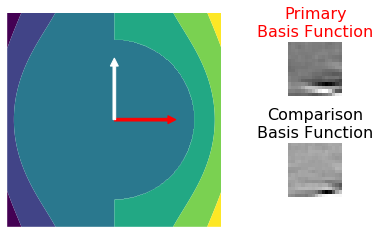

working on  92 92
BF indices = [ 92 ,  92 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


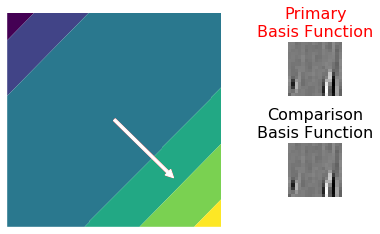

working on  92 93
BF indices = [ 92 ,  93 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


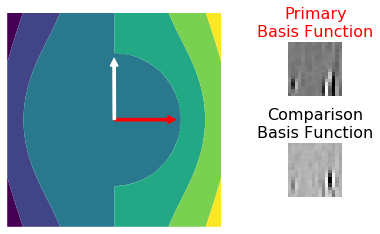

working on  92 94
BF indices = [ 92 ,  94 ]
bf0 norm =  1.0
bf1 norm =  0.9999999
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


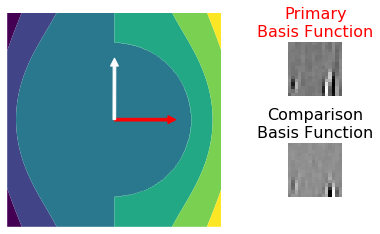

working on  92 95
BF indices = [ 92 ,  95 ]
bf0 norm =  1.0
bf1 norm =  0.9999998
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


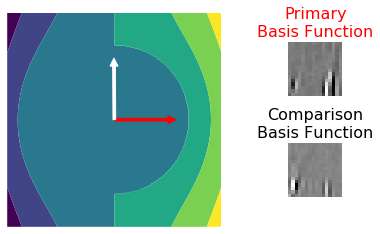

working on  96 96
BF indices = [ 96 ,  96 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


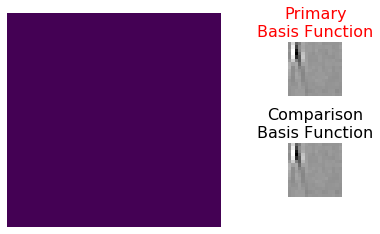

working on  96 97
BF indices = [ 96 ,  97 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


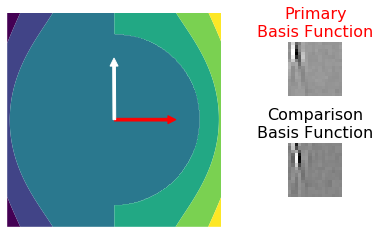

working on  96 98
BF indices = [ 96 ,  98 ]
bf0 norm =  1.0
bf1 norm =  1.0
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


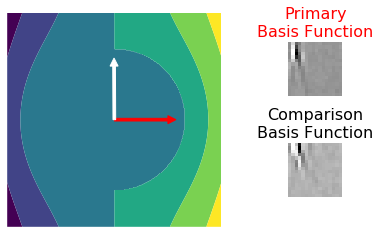

working on  96 99
BF indices = [ 96 ,  99 ]
bf0 norm =  1.0
bf1 norm =  1.0000001
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


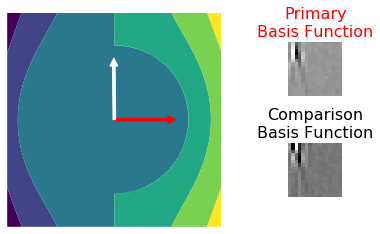

In [10]:
I = np.arange(10)*10
for i in np.arange(0, 100, 4):
    for j in np.arange(4):
        if i == j:
            continue
        try:
            print("working on ", i, i+j)
            vector_id = 4
            analyzer.bf_id0 = i#50#vectors[vector_id, 0] # RICA 83, 85; vae 4, 72; lca 3, 588
            analyzer.bf_id1 = i+j#10#vectors[vector_id, 1]
        #     fig, ax = plt.subplots(2)
        #     ax[0] = pf.clear_axis(ax[0])
        #     ax[0].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
        #     ax[0].set_title(str(analyzer.bf_id0))
        #     ax[1] = pf.clear_axis(ax[1])
        #     ax[1].imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
        #     ax[1].set_title(str(analyzer.bf_id1))
        #     plt.show()

            analyzer.bf0 = analyzer.bf_stats["basis_functions"][analyzer.bf_id0].reshape(
            (analyzer.model_params.num_pixels))
            analyzer.bf1 = analyzer.bf_stats["basis_functions"][analyzer.bf_id1].reshape(
            (analyzer.model_params.num_pixels))
            analyzer.bf0_norm = np.linalg.norm(analyzer.bf0)
            analyzer.bf1_norm = np.linalg.norm(analyzer.bf1)
            analyzer.bf0 = analyzer.bf0 / analyzer.bf0_norm
            analyzer.bf1 = analyzer.bf1 / analyzer.bf1_norm

            print("BF indices = [",analyzer.bf_id0,", ",analyzer.bf_id1,"]")
            print("bf0 norm = ", analyzer.bf0_norm)
            print("bf1 norm = ", analyzer.bf1_norm)

            num_imgs = int(228**2)
            x_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
            y_pts = np.linspace(-2.0, 2.0, int(np.sqrt(num_imgs)))
            X_mesh, Y_mesh = np.meshgrid(x_pts, y_pts)
            proj_datapoints = np.stack([X_mesh.reshape(num_imgs), Y_mesh.reshape(num_imgs)], axis=1)

            analyzer.proj_datapoints = proj_datapoints
            analyzer.proj_matrix, v = analyzer.bf_projections(analyzer.bf0, analyzer.bf1)
            analyzer.proj_neuron0 = np.dot(analyzer.proj_matrix, analyzer.bf0).T
            analyzer.proj_neuron1 = np.dot(analyzer.proj_matrix, analyzer.bf1).T
            analyzer.proj_v = np.dot(analyzer.proj_matrix, v).T

            analyzer.datapoints = np.stack([np.dot(analyzer.proj_matrix.T, analyzer.proj_datapoints[data_id,:])
            for data_id in range(num_imgs)]) #inject
            analyzer.datapoints, orig_shape = dp.reshape_data(analyzer.datapoints, flatten=False)[:2]
            analyzer.datapoints = {"test": Dataset(analyzer.datapoints, lbls=None, ignore_lbls=None, rand_state=analyzer.rand_state)}
            params={"whiten_data":analyzer.model_params.whiten_data}
            if params["whiten_data"]:
                params["whiten_method"] = analyzer.model_params.whiten_method
            analyzer.datapoints = analyzer.model.preprocess_dataset(analyzer.datapoints, params=params)
            analyzer.datapoints = analyzer.model.reshape_dataset(analyzer.datapoints, analyzer.model_params)
            analyzer.datapoints["test"].images /= np.max(np.abs(analyzer.datapoints["test"].images))
            analyzer.datapoints["test"].images *= 3*analyzer.analysis_params.input_scale

            activations = analyzer.compute_activations(analyzer.datapoints["test"].images)
            #activations = analyzer.evaluate_model(analyzer.datapoints["test"].images, [analyzer.model.module.u_list[1].name])[analyzer.model.module.u_list[1].name]
            activity_max = np.amax(np.abs(activations)) # Rescale between -1 and 1
            analyzer.norm_activity = activations / (activity_max + 0.00001)

            num_plots_y = 1
            num_plots_x = 2
            gs1 = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, width_ratios=[4, 1])
            fig = plt.figure(figsize=(6,6))
            curve_ax = pf.clear_axis(fig.add_subplot(gs1[0]))
            #cmap = plt.get_cmap('tab20b')
            cmap = plt.get_cmap('viridis')
            vmin = np.floor(np.min(analyzer.norm_activity))#0.0
            vmax = np.ceil(np.max(analyzer.norm_activity))#1.0

            #name_suffix = "continuous"
            #pts = curve_ax.scatter(analyzer.proj_datapoints[:,0], analyzer.proj_datapoints[:,1],
            #  vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.5, c=analyzer.norm_activity[:, analyzer.bf_id0], s=5.0)

            levels = 5
            name_suffix = ""
            contsf = curve_ax.contourf(X_mesh, Y_mesh,
            analyzer.norm_activity[:,analyzer.bf_id0].reshape(int(np.sqrt(num_imgs)),
            int(np.sqrt(num_imgs))), levels=levels, vmin=vmin, vmax=vmax, alpha=1.0, antialiased=True, cmap=cmap)

            curve_ax.arrow(0, 0, analyzer.proj_neuron0[0].item(),
            analyzer.proj_neuron0[1].item(), width=0.05, head_width=0.15,
            head_length=0.15, fc='r', ec='r')
            curve_ax.arrow(0, 0, analyzer.proj_neuron1[0].item(),
            analyzer.proj_neuron1[1].item(), width=0.05, head_width=0.15,
            head_length=0.15, fc='w', ec='w')
            #curve_ax.arrow(0, 0, analyzer.proj_v[0].item(), analyzer.proj_v[1].item(), width=0.05, head_width=0.15,
            # head_length=0.15, linestyle="-.", fc='k', ec='k')

            #curve_ax.set_title("Angle = "+"{:.2f}".format(analyzer.neuron_angles[bf_id0, bf_id1])+" deg", fontsize=16)
            curve_ax.set_ylim([-2, 2.0])
            curve_ax.set_xlim([-2, 2.0])
            curve_ax.set_aspect("equal")
            #cbar = pf.add_colorbar_to_im(pts, aspect=20, pad_fraction=0.5, labelsize=16, ticks=[vmin, vmax])
            #cbar.ax.set_yticklabels(["{:.0f}".format(vmin), "{:.0f}".format(vmax)])

            gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs1[1], wspace=2, hspace=-0.55)
            bf1_ax = pf.clear_axis(fig.add_subplot(gs2[0]))
            bf1_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id0], cmap="Greys_r")
            bf1_ax.set_title("Primary\nBasis Function", color='r', fontsize=16)
            bf2_ax = pf.clear_axis(fig.add_subplot(gs2[1]))
            bf2_ax.imshow(analyzer.bf_stats["basis_functions"][analyzer.bf_id1], cmap="Greys_r")
            bf2_ax.set_title("Comparison\nBasis Function", color='k', fontsize=16)
            fig.savefig(analyzer.analysis_out_dir+"/vis/neuron_response_contours_bf0id"+str(analyzer.bf_id0)+"_bf1id"+str(analyzer.bf_id1)+name_suffix+".png",
            transparent=True, bbox_inches="tight", pad_inches=0.01)
            plt.show()
            
        except:
            print(i, j, "failed to show iso-contour")

In [ ]:
class img_params():
    data_type = analysis_params.data_type
    num_images = 2
    extract_patches = False
    image_edge_size = analysis_params.image_edge_size
    data_dir = os.path.expanduser("~")+"/Work/Datasets/"
    rand_seed = analysis_params.rand_seed
    rand_state = np.random.RandomState(analysis_params.rand_seed)
full_img = dp.reshape_data(ds.get_data(img_params)["train"].images[0], flatten=False)[0]
analyzer.run_patch_recon_analysis(full_img, save_info=analysis_params.save_info)


In [ ]:
def run_patch_recon_analysis(self, full_image, save_info):
    """
    Break image into patches, compute recons, reassemble recons back into a full image
    """
    self.full_image = full_image
    if self.model_params.whiten_data:
      # FT method is the only one that works on full images
      wht_img, img_mean, ft_filter = dp.whiten_data(full_image,
        method="FT", lpf_cutoff=self.model_params.lpf_cutoff)
    else:
      wht_img = full_image
    img_patches = dp.extract_patches(wht_img,
      out_shape=(1, self.model_params.patch_edge_size, self.model_params.patch_edge_size, 1),
      overlapping=False, randomize=False, var_thresh=0.0)
    img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
    model_eval = self.evaluate_model(img_patches,
      ["inference/activity:0", "output/reconstruction:0"])
    recon_patches = model_eval["output/reconstruction:0"]
    a_vals = model_eval["inference/activity:0"]
    self.recon_frac_act = np.array(np.count_nonzero(a_vals) / float(a_vals.size))
    recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
    self.full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
    if self.model_params.whiten_data:
      self.full_recon = dp.unwhiten_data(self.full_recon, img_mean, ft_filter, method="FT")
    np.savez(self.analysis_out_dir+"savefiles/full_recon_"+save_info+".npz",
      data={"full_image":self.full_image, "full_recon":self.full_recon,
      "recon_frac_act":self.recon_frac_act})
    self.analysis_logger.log_info("Patch recon analysis is complete.")

In [69]:
def recon_images(analyzer, full_images):
    """
    Paramters: 
        full_images [np.ndarray]: list of images
    """
    model_params = analyzer.model_params
    wht_imgs, img_means, ft_filters = dp.whiten_data(full_image, method="FT", 
                                                  lpf_cutoff=model_params.lpf_cutoff)
    img_patches = dp.extract_patches(wht_imgs, 
                                     out_shape=(1, model_params.patch_edge_size, 
                                                model_params.patch_edge_size, 1),
                                     overlapping=False, randomize=False, var_thresh=0.0)
    img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
    model_eval = analyzer.evaluate_model(img_patches,
      ["inference/activity:0", "output/reconstruction:0"])
    recon_patches = model_eval["output/reconstruction:0"]
    a_vals = model_eval["inference/activity:0"]
    recon_frac_act = np.array(np.count_nonzero(a_vals) / float(a_vals.size))
    recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
    full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
    if model_params.whiten_data:
          full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")
    return full_recon, recon_frac_act

In [70]:
analyzer.model_params.__dict__.keys()

dict_keys(['batch_size', 'center_data', 'contrast_normalize', 'cp_int', 'cp_latest_filename', 'cp_load', 'cp_load_dir', 'cp_load_latest_filename', 'cp_load_name', 'cp_load_step', 'cp_load_var', 'cp_load_ver', 'cp_save_dir', 'data_dir', 'data_shape', 'data_type', 'device', 'disp_dir', 'dt', 'eps', 'extract_patches', 'gen_plot_int', 'log_dir', 'log_int', 'log_to_file', 'lpf_cutoff', 'lpf_data', 'max_cp_to_keep', 'model_name', 'model_out_dir', 'model_type', 'norm_data', 'norm_weights', 'num_groups', 'num_images', 'num_neurons', 'num_patches', 'num_pixels', 'num_steps', 'optimizer', 'out_dir', 'overlapping_patches', 'patch_edge_size', 'patch_variance_threshold', 'rand_seed', 'randomize_patches', 'rescale_data', 'save_dir', 'save_plots', 'schedule', 'standardize_data', 'tau', 'tf_standardize_data', 'val_on_cp', 'vectorize_data', 'version', 'whiten_batch_size', 'whiten_data', 'whiten_method'])

In [71]:
full_image = np.repeat(analyzer.full_image, 3, axis=0)
full_recon = recon_images(analyzer, full_image)

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


In [74]:
full_recon

AttributeError: 'tuple' object has no attribute 'shape'

In [95]:
model_params = analyzer.model_params
wht_imgs, img_mean, ft_filter = dp.whiten_data(full_image, method="FT", 
                                              lpf_cutoff=model_params.lpf_cutoff)
img_patches = dp.extract_patches(wht_imgs, 
                                 out_shape=(1, model_params.patch_edge_size, 
                                            model_params.patch_edge_size, 1),
                                 overlapping=False, randomize=False, var_thresh=0.0)
img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
model_eval = analyzer.evaluate_model(img_patches,
  ["inference/activity:0", "output/reconstruction:0"])
recon_patches = model_eval["output/reconstruction:0"]
a_vals = model_eval["inference/activity:0"]
recon_frac_act = np.array(np.count_nonzero(a_vals) / float(a_vals.size))
recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
if model_params.whiten_data:
  full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


In [100]:
def recon_images(analyzer, full_images):
    if analyzer.model_params.whiten_data:
      # FT method is the only one that works on full images
      wht_img, img_mean, ft_filter = dp.whiten_data(full_image,
        method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
    else:
      wht_img = full_image
    img_patches = dp.extract_patches(wht_img,
      out_shape=(1, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size, 1),
      overlapping=False, randomize=False, var_thresh=0.0)
    img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
    model_eval = analyzer.evaluate_model(img_patches,
      ["inference/activity:0", "output/reconstruction:0"])
    recon_patches = model_eval["output/reconstruction:0"]
    a_vals = model_eval["inference/activity:0"]
    recon_frac_act = np.array(np.count_nonzero(a_vals) / float(a_vals.size))
    recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
    full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
    if analyzer.model_params.whiten_data:
      full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")
    return full_recon, recon_frac_act

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v4_3.0_0.3-1000000


In [116]:
normed_image = (
  (full_image - np.min(full_image))
  / (np.max(full_image) - np.min(full_image))).astype(np.float32)

normed_recon = (
  (full_recon - np.min(full_recon))
  / (np.max(full_recon) - np.min(full_recon))).astype(np.float32)

group_size = analyzer.model_params.num_neurons // analyzer.model_params.num_groups

4

In [118]:
a_vals.shape

(192, 768)

In [87]:
full_recon.shape

(3, 128, 128, 1)

In [98]:
full_recon

array([[[[-68232.68168652],
         [-68232.68040702],
         [-68232.6806362 ],
         ...,
         [-68232.68783801],
         [-68232.68778311],
         [-68232.68653573]],

        [[-68232.68312741],
         [-68232.68159717],
         [-68232.6817736 ],
         ...,
         [-68232.68930089],
         [-68232.68926461],
         [-68232.68796894]],

        [[-68232.68379025],
         [-68232.68232651],
         [-68232.68280546],
         ...,
         [-68232.68959843],
         [-68232.68946557],
         [-68232.68828096]],

        ...,

        [[-68232.68148846],
         [-68232.6812003 ],
         [-68232.68088077],
         ...,
         [-68232.68252491],
         [-68232.68199091],
         [-68232.68160392]],

        [[-68232.68181322],
         [-68232.68132982],
         [-68232.68089207],
         ...,
         [-68232.68335701],
         [-68232.68275551],
         [-68232.68214449]],

        [[-68232.68210985],
         [-68232.68124506],
         [

In [114]:
analyzer.model_params.__dict__

{'batch_size': 80,
 'center_data': False,
 'contrast_normalize': False,
 'cp_int': 100000,
 'cp_latest_filename': 'latest_checkpoint_v4_3.0_0.3',
 'cp_load': False,
 'cp_load_dir': '/home/ryanchan/Work/Projects/pretrain/checkpoints/',
 'cp_load_latest_filename': 'latest_checkpoint_v0.0',
 'cp_load_name': 'pretrain',
 'cp_load_step': None,
 'cp_load_var': ['phi'],
 'cp_load_ver': '0.0',
 'cp_save_dir': '/home/ryanchan/Work/Projects/lca_subspace_vh/analysis/4_3.0_0.3//checkpoints/',
 'data_dir': '/home/ryanchan/Work/Datasets//vanHateren/',
 'data_shape': [256],
 'data_type': 'vanhateren',
 'device': '/gpu:0',
 'disp_dir': '/home/ryanchan/Work/Projects/lca_subspace_vh/analysis/4_3.0_0.3//vis/',
 'dt': 0.001,
 'eps': 1e-12,
 'extract_patches': True,
 'gen_plot_int': 100000,
 'log_dir': '/home/ryanchan/Work/Projects/lca_subspace_vh/analysis/4_3.0_0.3//logfiles/',
 'log_int': 100,
 'log_to_file': True,
 'lpf_cutoff': 0.7,
 'lpf_data': False,
 'max_cp_to_keep': 1,
 'model_name': 'lca_subspace

In [213]:
with tf.Session() as sess:
    x = np.arange(50).reshape(5, 10)
    print(x)
    I = tf.slice(x, [3, 0], [1, 10])
    print(sess.run(tf.transpose(I)))

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]]
[[30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]]


In [220]:
x = np.zeros(shape=(256, 64))
for i in range(64):
    x[i:(i+1)*4, i] = 1.
x[:8, :]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0